# Predicting molecular properties with machine learning

### Dataset

Dataset - Quantum chemistry structures and properties of 134 kilo molecules (https://www.nature.com/articles/sdata201422).

It contains geometric, energetic, electronic, and thermodynamic properties for 134k stable small organic molecules.

The molecules are composed of carbon (C), hydrogen (H), oxygen (O), nitrogen (N), and fluorine (F).

### Objective

The objective of the project is to predict the molecular properties of these small organic molecules using the Coulomb matrix representation.

We will use the eigenvalues of the Coulomb matrix, which serve as a crucial descriptor for capturing the electronic structure of molecules for predicting molecular properties.

### Properties

| No. | Property | Unit         | Description                            |
|-----|----------|--------------|----------------------------------------|
| 1   | tag      | —            | ‘gdb9’ string to facilitate extraction|
| 2   | i        | —            | Consecutive, 1-based integer identifier|
| 3   | A        | GHz          | Rotational constant                   |
| 4   | B        | GHz          | Rotational constant                   |
| 5   | C        | GHz          | Rotational constant                   |
| 6   | μ        | D            | Dipole moment                         |
| 7   | α        | a³           | Isotropic polarizability              |
| 8   | εHOMO    | Ha           | Energy of HOMO                        |
| 9   | εLUMO    | Ha           | Energy of LUMO                        |
| 10  | εgap     | Ha           | Gap (εLUMO − εHOMO)                   |
| 11  | /R2S     | a²           | Electronic spatial extent             |
| 12  | zpve     | Ha           | Zero point vibrational energy         |
| 13  | U0       | Ha           | Internal energy at 0 K                |
| 14  | U        | Ha           | Internal energy at 298.15 K           |
| 15  | H        | Ha           | Enthalpy at 298.15 K                  |
| 16  | G        | Ha           | Free energy at 298.15 K               |
| 17  | C v      | cal/mol·K    | Heat capacity at 298.15 K             |


In [31]:
import pandas as pd
import os
import opendatasets as od
from tqdm import tqdm
from pathlib import Path
import shutil
import random
from coulumb_utils.xyz import read_xyz, create_dataframe_from_xyz
from coulumb_utils.calculate_coulumb_matrix import calculate_coulomb_matrix
from coulumb_utils.sort_molecules import sort_by_row_norm
from coulumb_utils.normalize import normalize_min_max
from coulumb_utils.eigen_padd import compute_eigenvalues, padd_eig, padd_matrix
from coulumb_utils.standardize import standardize_matrix
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator,ScalarFormatter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from xgboost import plot_importance

# Download dataset

The dataset is on Kaggle - https://www.kaggle.com/datasets/mariovozza5/qm9-molecules

In [2]:

dataset = "https://www.kaggle.com/datasets/mariovozza5/qm9-molecules"

if not os.path.exists("qm9-molecules"): od.download(dataset)

# Load xyz files

The dataset contains XYZ format files to store the atomatic coordinates and calculated properties of the molecules.

This is a widespread plain text format for encoding Cartesian coordinates of molecules.

https://open-babel.readthedocs.io/en/latest/FileFormats/XYZ_cartesian_coordinates_format.html

Example XYZ file from the dataset - qm9-molecules/data/qm9_460.xyz

In [3]:
work_path = Path("./qm9-molecules/")
data_path = work_path.joinpath("data")

subset_size = 1000

df = create_dataframe_from_xyz(data_path, subset_size)
df_sorted = df.sort_values('index', ascending=True)

df_sorted.head(10)

100%|██████████| 1000/1000 [00:00<00:00, 9175.86it/s]


,filename,n_atoms,index,A,B,C,mu,alpha,homo,lumo,gap,R2,zpve,U0,U,H,G,Cv
600,qm9_483,12,483,6.50004,3.85598,3.01225,2.2569,45.92,-0.2318,0.0706,0.3024,464.1350,0.095993,-306.309029,-306.303682,-306.302738,-306.337396,20.187
582,qm9_509,12,509,9.01950,2.12799,1.74027,4.5664,52.58,-0.2408,-0.0172,0.2236,680.2345,0.095665,-302.567313,-302.560613,-302.559669,-302.597876,22.098
299,qm9_527,14,527,15.53869,1.41482,1.33271,4.2405,54.99,-0.2476,0.0230,0.2706,867.8577,0.119718,-266.616319,-266.609198,-266.608253,-266.647430,23.932
711,qm9_559,12,559,9.75537,2.43167,2.14750,2.8301,46.71,-0.2487,-0.0357,0.2129,575.5626,0.095537,-306.349558,-306.343561,-306.342617,-306.379880,19.792
344,qm9_562,13,562,9.86113,2.62587,2.15831,2.0739,52.85,-0.2475,0.0325,0.2800,592.3635,0.108198,-286.484121,-286.477884,-286.476940,-286.514266,21.051
603,qm9_610,13,610,6.92044,2.46124,2.05055,3.1960,51.36,-0.2482,-0.0262,0.2220,616.9206,0.107279,-286.474509,-286.468144,-286.467200,-286.504520,22.227
989,qm9_949,13,949,5.67429,2.62513,1.79479,1.2550,62.42,-0.2191,0.0010,0.2201,662.6765,0.104479,-307.387663,-307.382167,-307.381222,-307.416622,21.832
191,qm9_978,12,978,3.80501,3.40231,1.80937,0.8686,52.74,-0.1809,0.0344,0.2153,645.8036,0.090579,-360.525610,-360.519011,-360.518067,-360.555895,24.081
348,qm9_1159,12,1159,3.40750,2.31772,1.89688,3.2896,56.29,-0.2965,-0.0101,0.2864,714.3287,0.087111,-323.344400,-323.336715,-323.335771,-323.375674,27.481
890,qm9_1714,15,1714,3.62069,2.52138,1.96169,3.0523,57.32,-0.2551,-0.0306,0.2245,706.9559,0.123450,-345.640098,-345.632751,-345.631807,-345.672014,25.478


# Data exploration

We visualize the data so we can get an idea of the targets we can predict and make more informed decisions on model selection and evaluation metrics.

By visualizing the distribution, we can also identify any potential outliers or skewness in the data that may require special handling during preprocessing.

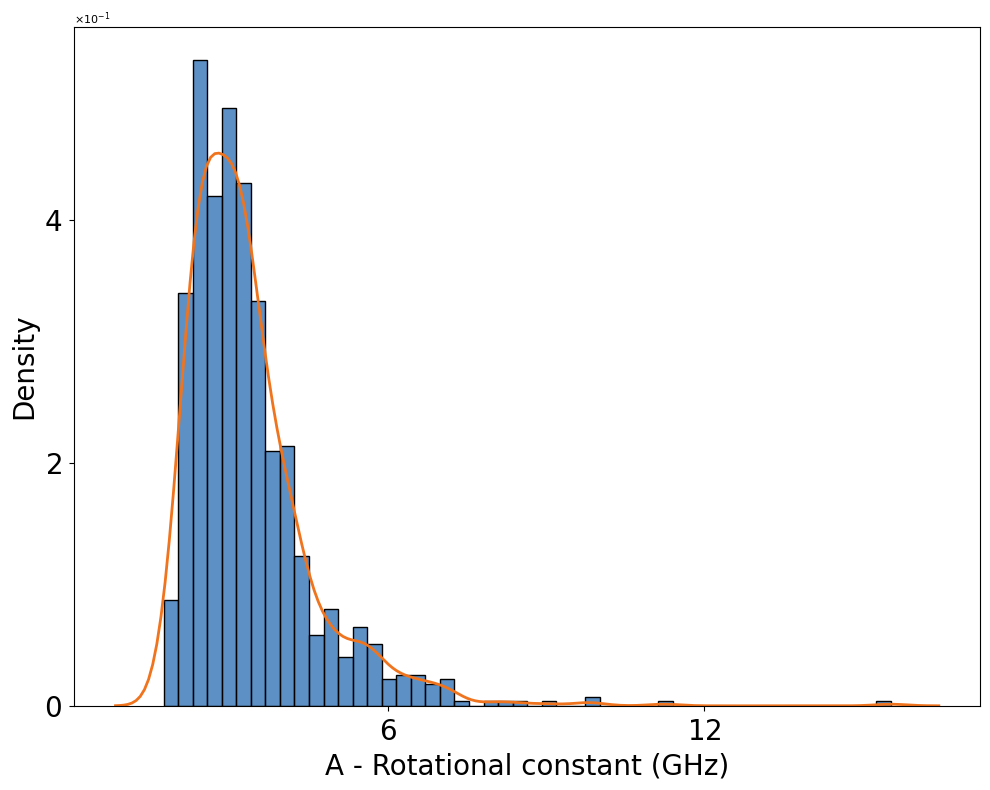

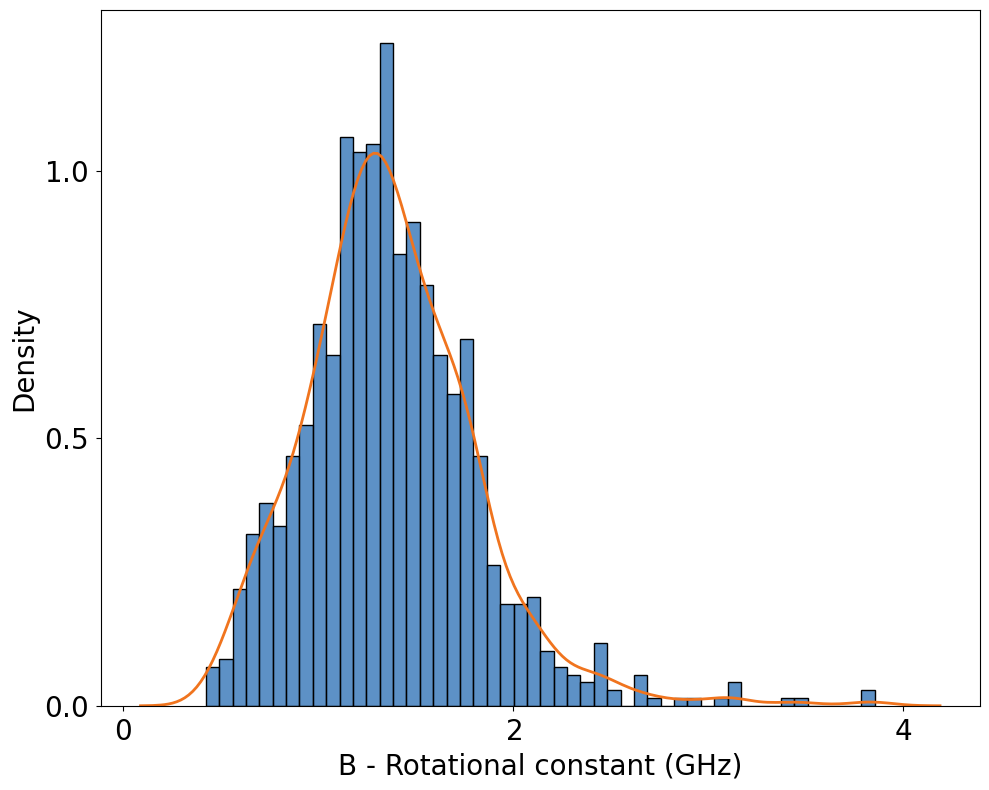

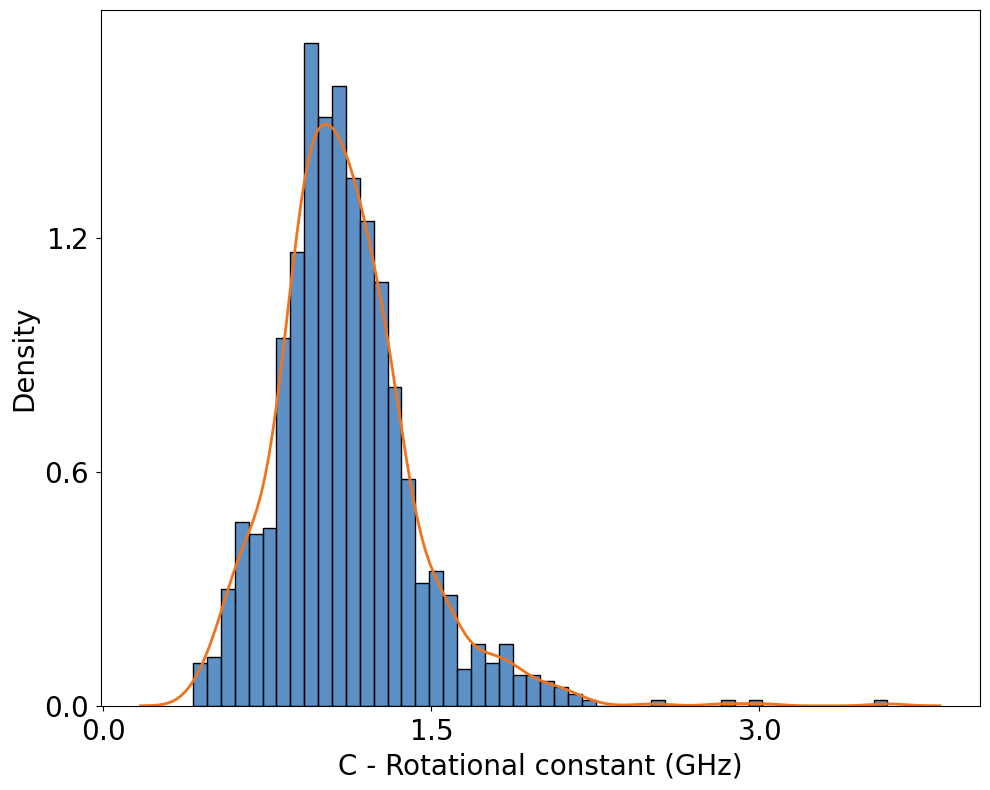

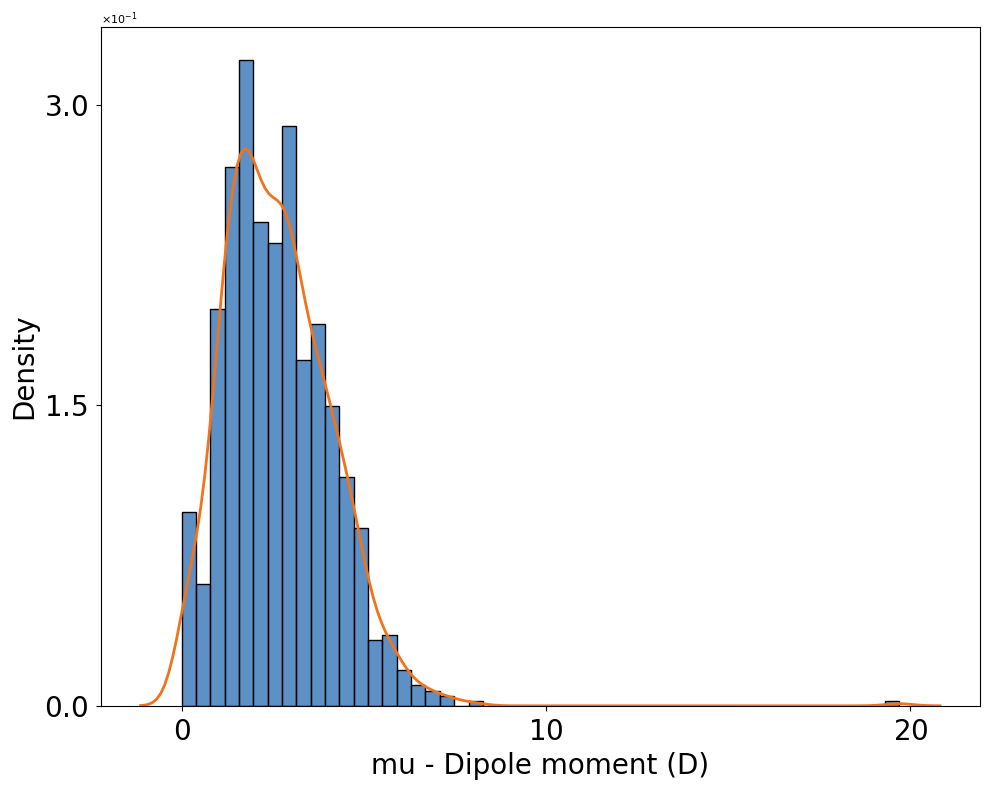

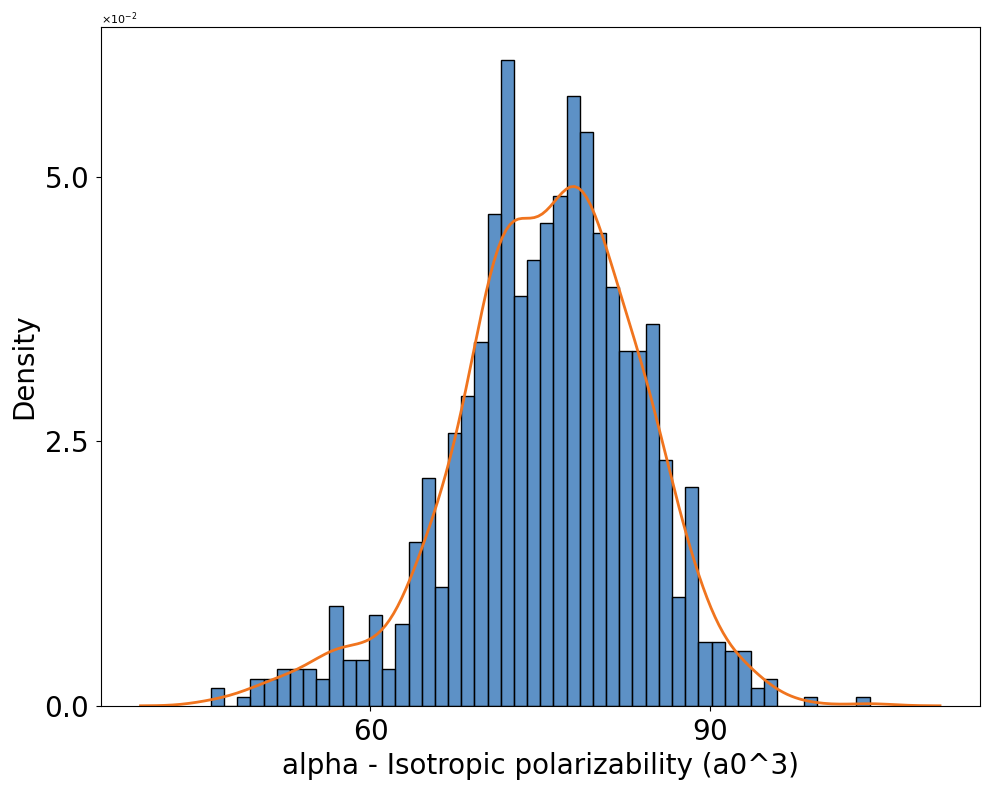

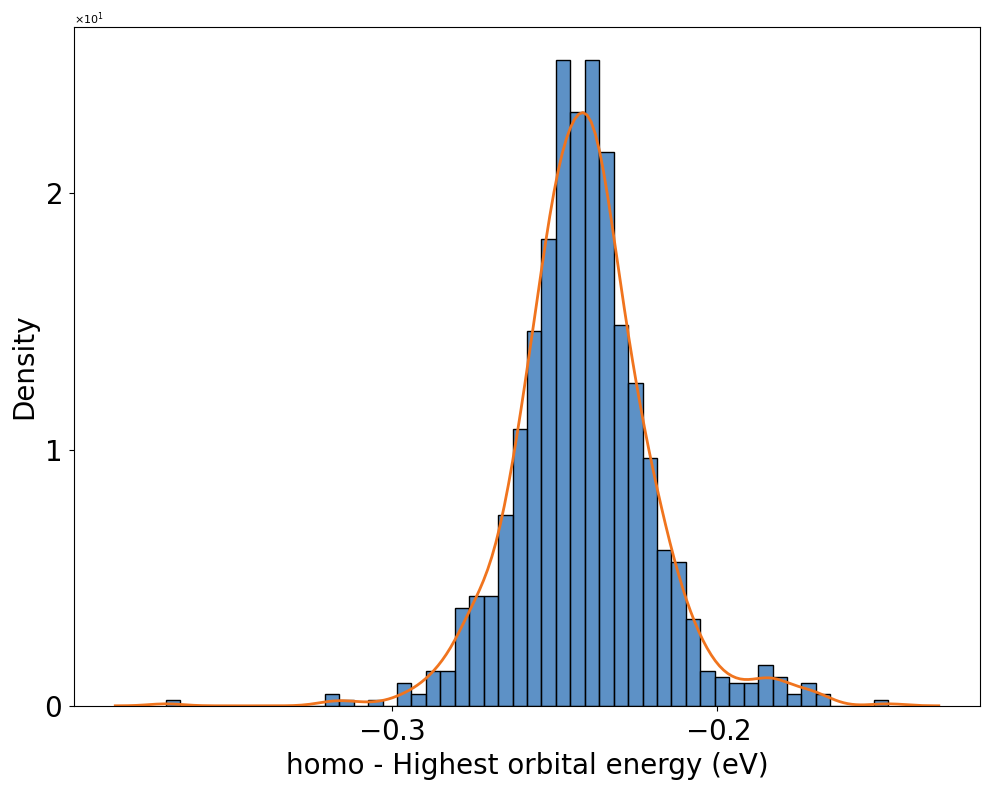

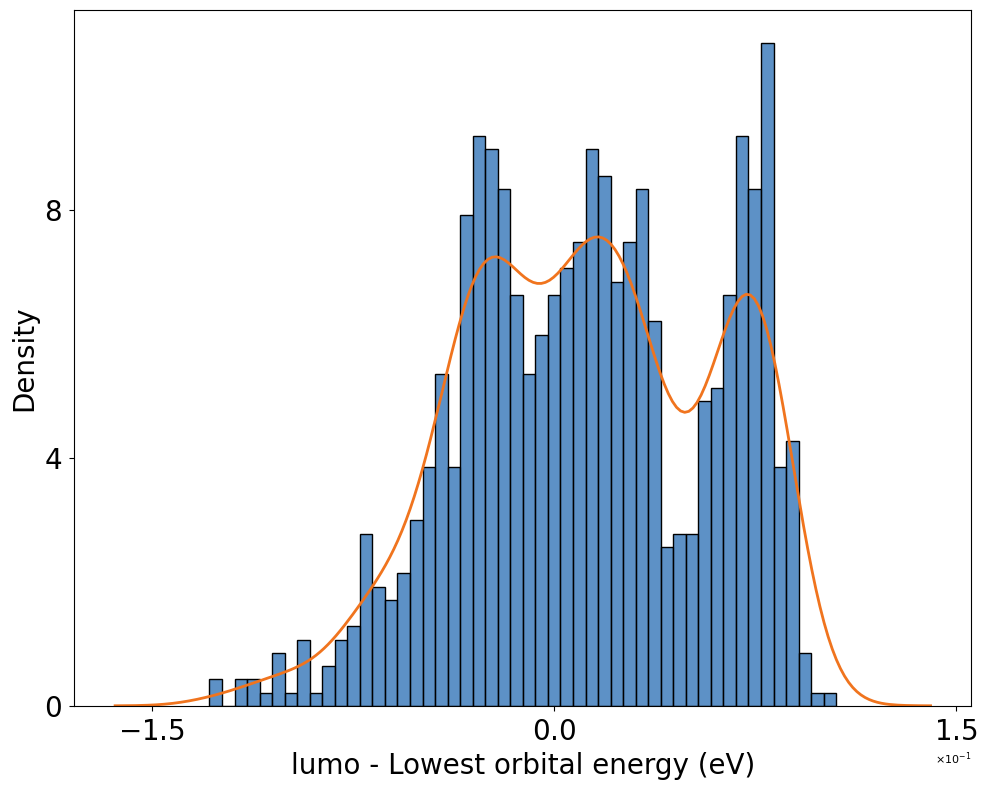

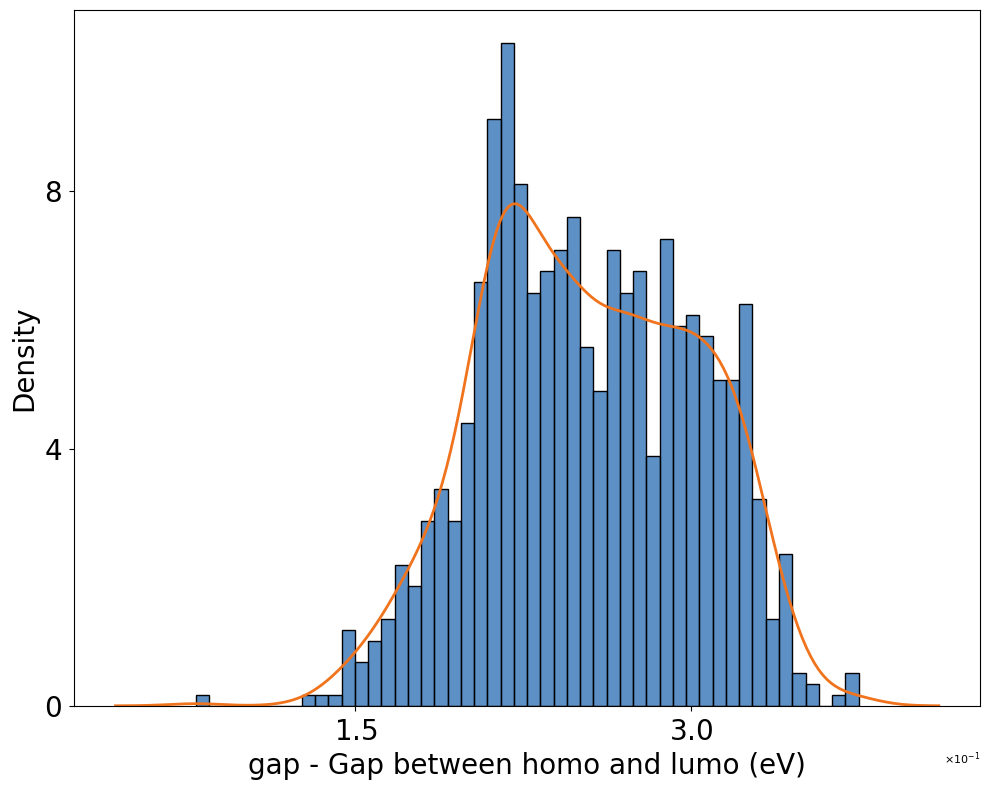

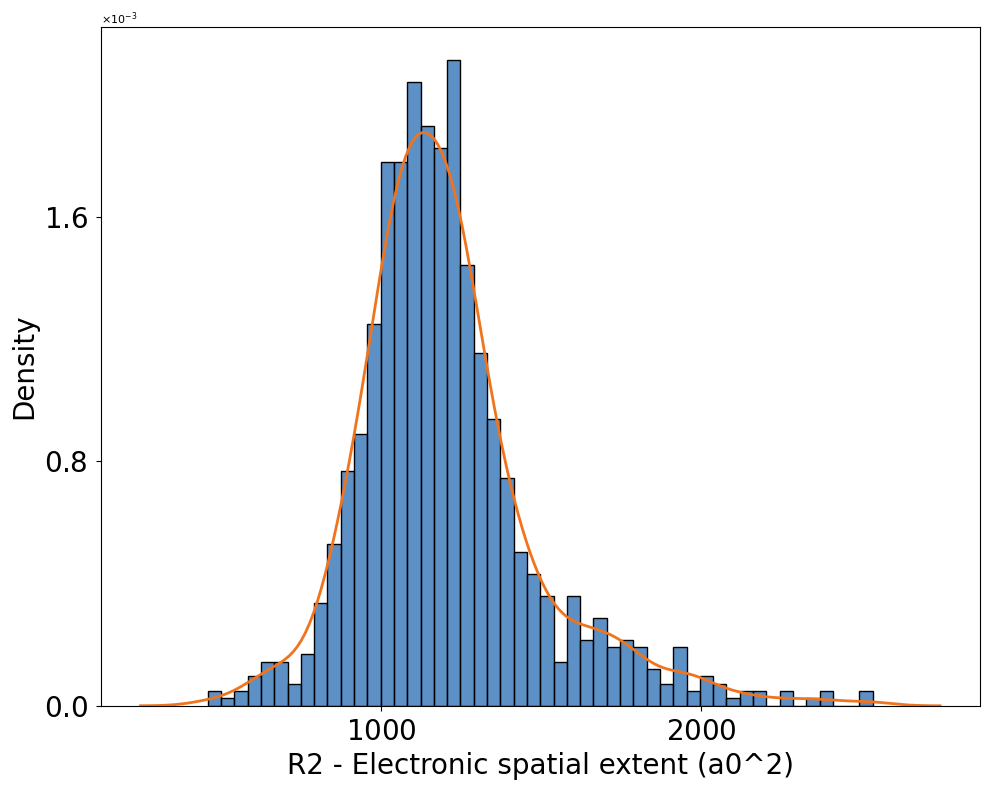

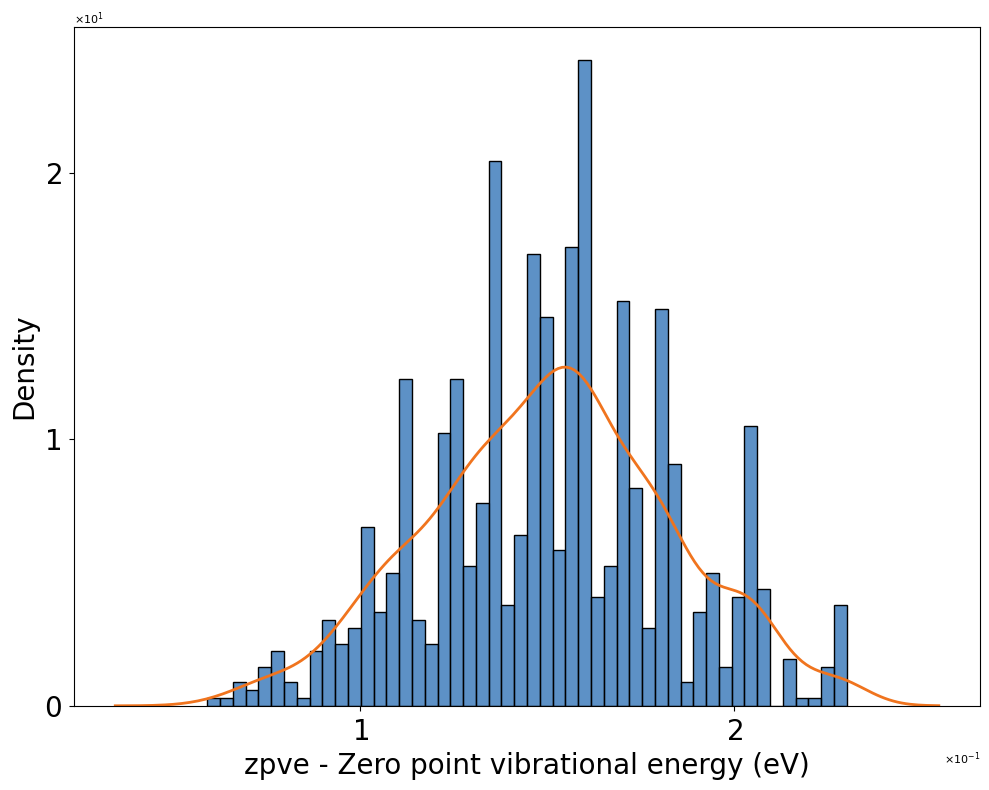

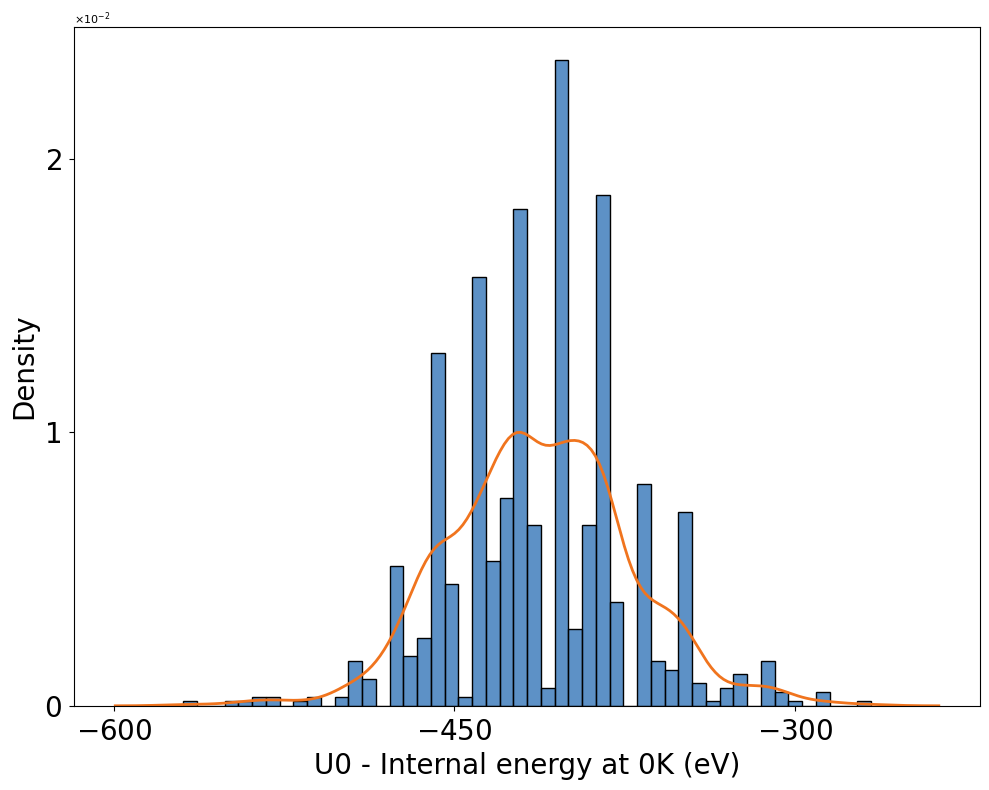

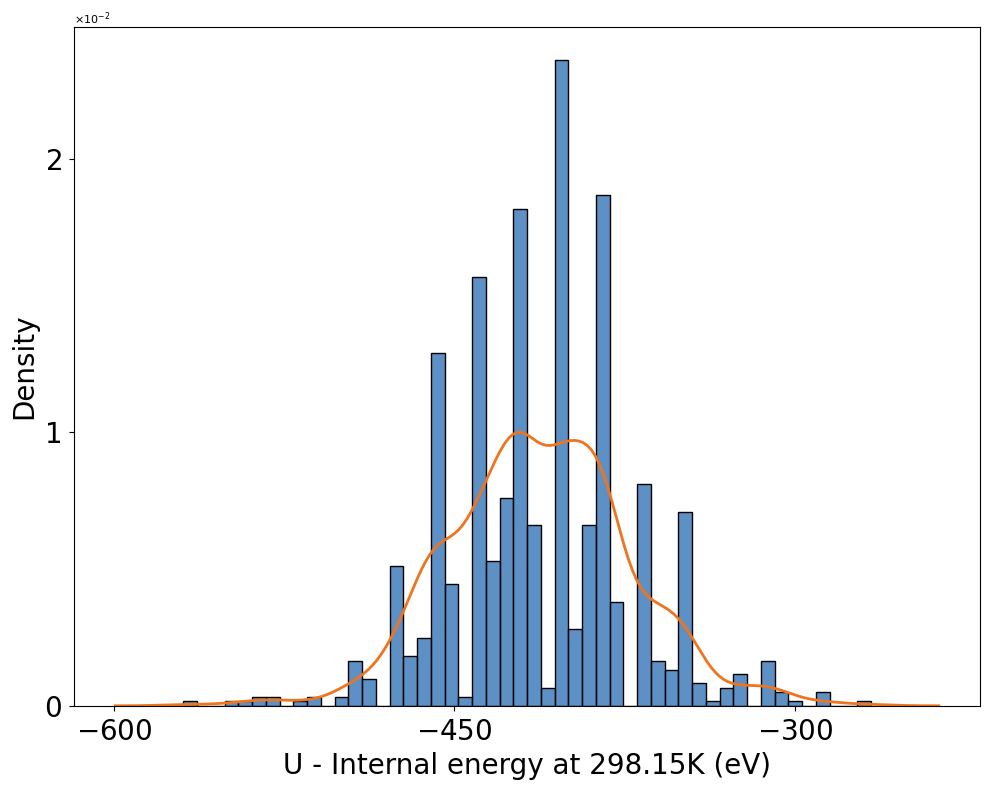

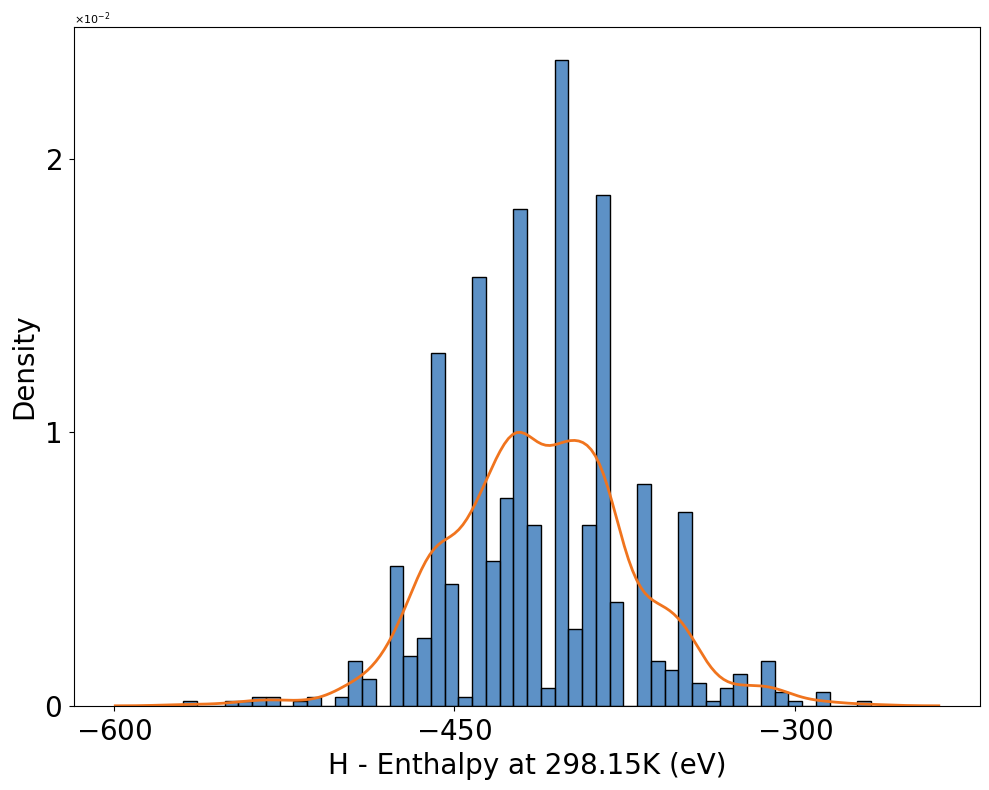

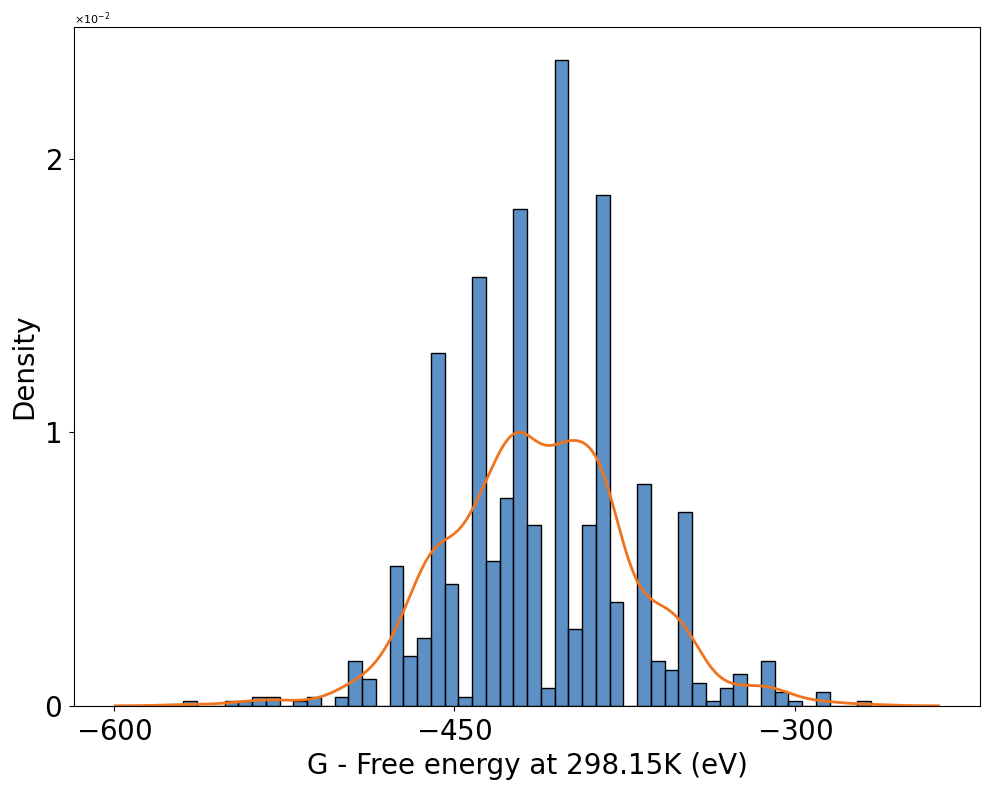

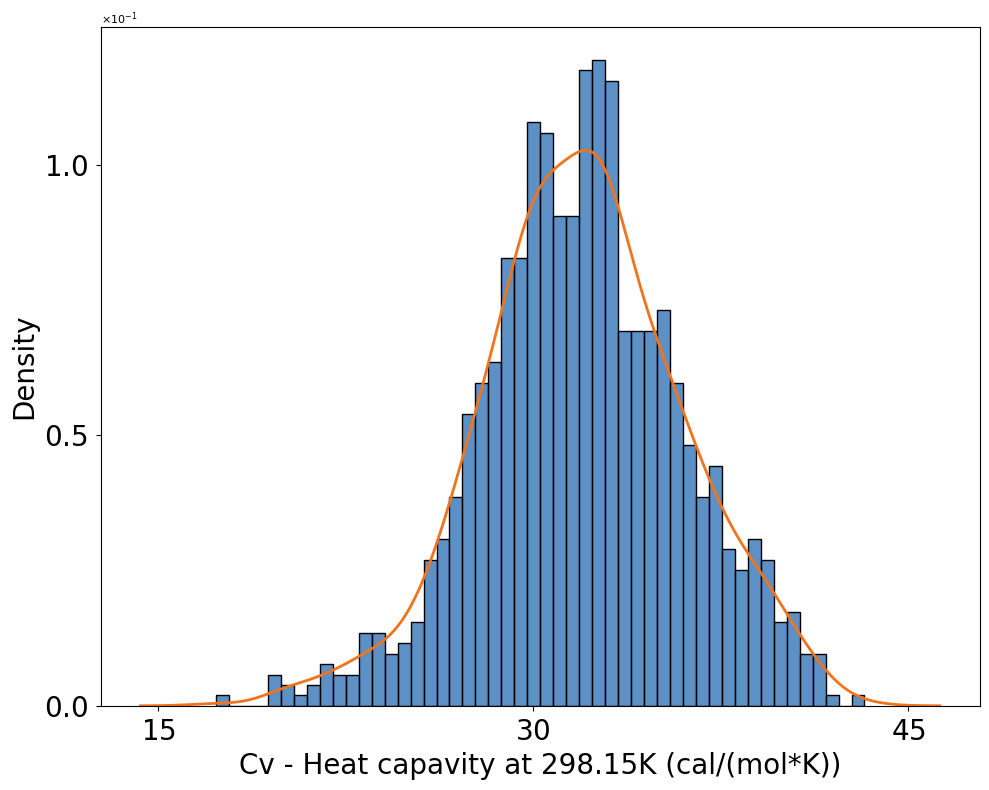

In [4]:
colors = ["#F0741E", "#276CB3"]
plt.style.use("seaborn-v0_8-paper")

target_list = ["A","B",	"C", "mu", "alpha", "homo", "lumo",	"gap", "R2", "zpve", "U0", "U", "H", "G", "Cv"]

target_labels = {
    "A": ("A - Rotational constant (GHz)", "Density"),
    "B": ("B - Rotational constant (GHz)", "Density"),
    "C": (
        "C - Rotational constant (GHz)",
        "Density",
    ),
    "mu": (
        "mu - Dipole moment (D)",
        "Density",
    ),
    "alpha": (
        "alpha - Isotropic polarizability (a0^3)",
        "Density",
    ),
    "homo": (
        "homo - Highest orbital energy (eV)",
        "Density",
    ),
    "lumo": (
        "lumo - Lowest orbital energy (eV)",
        "Density",
    ),
    "gap": (
        "gap - Gap between homo and lumo (eV)",
        "Density",
    ),
    "R2": (
        "R2 - Electronic spatial extent (a0^2)",
        "Density",
    ),
    "zpve": (
        "zpve - Zero point vibrational energy (eV)",
        "Density",
    ),
    "U0": (
        "U0 - Internal energy at 0K (eV)",
        "Density",
    ),
    "U": (
        "U - Internal energy at 298.15K (eV)",
        "Density",
    ),
    "H": (
        "H - Enthalpy at 298.15K (eV)",
        "Density",
    ),
    "G": (
        "G - Free energy at 298.15K (eV)",
        "Density",
    ),
    "Cv": (
        "Cv - Heat capavity at 298.15K (cal/(mol*K))",
        "Density",
    ),
}

for target in target_list:

    fig = plt.figure(figsize=(10, 8))

    ax = fig.add_subplot(1, 1, 1)

    sns.histplot(
        x=df_sorted[f"{target}"],
        fill=True,
        linewidth=1,
        kde=False,
        stat="density",
        color=colors[1],
        ax=ax,
        bins=50,
    )

    sns.kdeplot(x=df_sorted[f"{target}"], linewidth=2, color=colors[0], ax=ax)

    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.set_xlabel(target_labels[target][0], fontsize=20)
    ax.set_ylabel(target_labels[target][1], fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.tight_layout()
    plt.show()


# Calculate and visualize Coulumb matrices

A Coulumb matrix is a simple global descriptor which mimics the electrostatic interaction between nuclei.

![coulumb_matrix.png](images/coulumb_matrix.png)

The Coulomb matrix for each molecule has dimensions N x N atoms and the number of eigenvalues is equal to N atoms.

Padding is applied to the eigenvalues. This standardizes the size of the eigenvalue vectors across all molecules to a fixed dimension - max(N atoms).

This ensures that all eigenvalue vectors have the same size, making them compatible for use in machine learning models.

NOTE: The matrices displayed here are without padding and they have been scaled to the size of an image (each individual square representing an element of the Coulomb matrix has different dimensions).

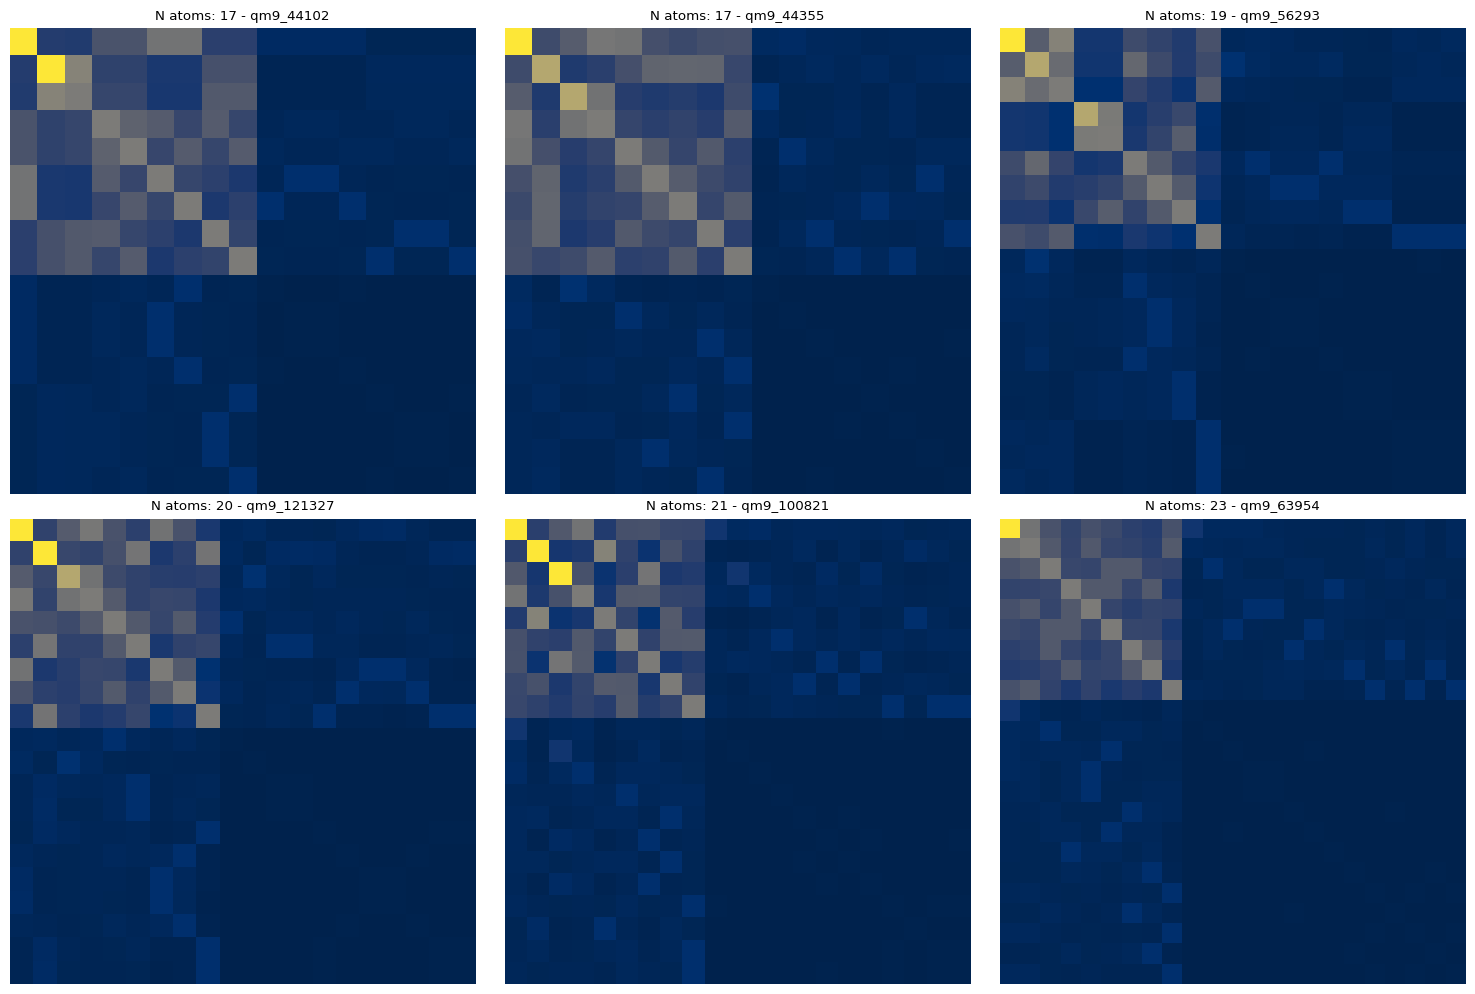

In [5]:
def display_random_images(data_path, n=6, num_cols=3):
    if not isinstance(num_cols, int):
        raise TypeError("ERROR: num_cols must be an integer")
    if not isinstance(n, int):
        raise TypeError("ERROR: n must be an integer")
    if num_cols <= 0:
        raise ValueError("ERROR: num_cols must be greater than zero")
    if n <= 0:
        raise ValueError("ERROR: n must be greater than zero")

    file_list = list(data_path.glob('*.xyz'))
    selected_files = random.sample(file_list, n)

    num_rows = (n + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols,5*num_rows))

    axes = axes.flatten()

    for i, file_path in enumerate(selected_files):
        atomic_numbers, coordinates = read_xyz(file_path)
        c_mat = calculate_coulomb_matrix(atomic_numbers=atomic_numbers, coordinates=coordinates)
        c_mat = sort_by_row_norm(c_mat)
        image = c_mat

        axes[i].imshow(image, cmap="cividis")
        axes[i].set_title(f"N atoms: {len(atomic_numbers)} - {file_path.stem}" )
        axes[i].axis('off')

    for j in range(i + 1, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

display_random_images(data_path)

# Calculation and padding of eigenvalues

In [6]:
resolution = df_sorted["n_atoms"].max()
print("MAX ATOM NUMBER: ",resolution)
eig_list = []
data = {}
file_list = df_sorted["filename"].to_list()
for file_path in tqdm(file_list):

    atomic_numbers, coordinates = read_xyz(data_path.joinpath(file_path + ".xyz"))
    c_mat = calculate_coulomb_matrix(atomic_numbers=atomic_numbers, coordinates=coordinates)
    c_mat = sort_by_row_norm(c_mat)
    eig = compute_eigenvalues(matrix=c_mat)
    eig = eig.reshape(-1, 1)
    eig = padd_eig(matrix=eig, resolution=resolution)
    eig = normalize_min_max(matrix=eig)
    data[file_path] = eig

MAX ATOM NUMBER:  25


100%|██████████| 1000/1000 [00:00<00:00, 5593.47it/s]


In [7]:
data_list = []
for filename, eig_vector in data.items():
    row = {'filename': filename}
    for i, value in enumerate(eig_vector):
        row[f'eig_{i+1}'] = value[0]
    data_list.append(row)

df_eigenvalue = pd.DataFrame(data_list)

df_eigenvalue.head()

,filename,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,eig_8,eig_9,eig_10,eig_11,eig_12,eig_13,eig_14,eig_15,eig_16,eig_17,eig_18,eig_19,eig_20,eig_21,eig_22,eig_23,eig_24,eig_25
0,qm9_483,1.0,0.359689,0.189762,0.123631,0.071383,0.040220,0.004335,0.003928,0.000000,0.000352,0.002209,0.001611,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464
1,qm9_509,1.0,0.408681,0.246738,0.123992,0.060049,0.034974,0.000000,0.000859,0.003091,0.004705,0.005520,0.005490,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915
2,qm9_527,1.0,0.448216,0.245408,0.132659,0.086707,0.036754,0.000000,0.001542,0.003208,0.004832,0.007703,0.006070,0.006746,0.006640,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247
3,qm9_559,1.0,0.428377,0.183954,0.132322,0.068973,0.042705,0.000000,0.001998,0.002796,0.005611,0.004025,0.004737,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548
4,qm9_562,1.0,0.328554,0.189873,0.135620,0.082882,0.028632,0.000000,0.000550,0.002910,0.005871,0.004937,0.005313,0.005324,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764


In [8]:
target = "Cv" # can be one of ["A","B","C","mu","alpha","homo","lumo","gap","R2","zpve","U0","U","H","G","Cv"]

df_merged = pd.merge(df_eigenvalue, df_sorted[['filename', target]], on='filename', how='left')

df_merged.head(10)

,filename,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,eig_8,eig_9,eig_10,eig_11,eig_12,eig_13,eig_14,eig_15,eig_16,eig_17,eig_18,eig_19,eig_20,eig_21,eig_22,eig_23,eig_24,eig_25,Cv
0,qm9_483,1.0,0.359689,0.189762,0.123631,0.071383,0.040220,0.004335,0.003928,0.000000,0.000352,0.002209,0.001611,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,0.004464,20.187
1,qm9_509,1.0,0.408681,0.246738,0.123992,0.060049,0.034974,0.000000,0.000859,0.003091,0.004705,0.005520,0.005490,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,0.005915,22.098
2,qm9_527,1.0,0.448216,0.245408,0.132659,0.086707,0.036754,0.000000,0.001542,0.003208,0.004832,0.007703,0.006070,0.006746,0.006640,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,0.007247,23.932
3,qm9_559,1.0,0.428377,0.183954,0.132322,0.068973,0.042705,0.000000,0.001998,0.002796,0.005611,0.004025,0.004737,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,0.005548,19.792
4,qm9_562,1.0,0.328554,0.189873,0.135620,0.082882,0.028632,0.000000,0.000550,0.002910,0.005871,0.004937,0.005313,0.005324,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,0.005764,21.051
5,qm9_610,1.0,0.427356,0.205141,0.120894,0.077288,0.046448,0.000000,0.001777,0.002863,0.003643,0.005277,0.005891,0.005706,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,0.006152,22.227
6,qm9_949,1.0,0.377365,0.228679,0.167184,0.057263,0.067247,0.024308,0.000000,0.006553,0.005712,0.004442,0.003836,0.003450,0.007184,0.007184,0.007184,0.007184,0.007184,0.007184,0.007184,0.007184,0.007184,0.007184,0.007184,0.007184,21.832
7,qm9_978,1.0,0.350259,0.252232,0.161095,0.100300,0.038954,0.020268,0.003906,0.003089,0.001905,0.000422,0.000000,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,0.004514,24.081
8,qm9_1159,1.0,0.344540,0.291450,0.184611,0.094191,0.042186,0.020118,0.000000,0.001490,0.002942,0.005424,0.005406,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,0.005838,27.481
9,qm9_1714,1.0,0.403102,0.228007,0.106462,0.122993,0.067971,0.033643,0.000000,0.001201,0.001619,0.002617,0.005201,0.004891,0.004549,0.004598,0.005212,0.005212,0.005212,0.005212,0.005212,0.005212,0.005212,0.005212,0.005212,0.005212,25.478


# Hyperparameter optimization

In [23]:
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_mse = -grid_search.best_score_
    return best_params, best_mse

# Cross-validation

In [24]:
def evaluate_with_cv(models, X, y, cv=5):
    results = []
    for model in models:
        model_name = type(model).__name__
        
        cv_mse = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        cv_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')
        
        results.append({
            'Model': model_name,
            'Mean CV MSE': cv_mse.mean(),
            'Std CV MSE': cv_mse.std(),
            'Mean CV R2': cv_r2.mean(),
            'Std CV R2': cv_r2.std()
        })
    return pd.DataFrame(results)

# Models comparison

In [32]:
def regression_model_comparison(df, target):
    X = df.drop(['filename', target], axis=1)
    y = df[target]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    models = [
        LinearRegression(),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor(random_state=42),
        SVR(),
        KNeighborsRegressor()
    ]
    
    param_grids = {
        'RandomForestRegressor': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
        'GradientBoostingRegressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
        'SVR': {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']},
        'KNeighborsRegressor': {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}
    }
    
    cv_results = evaluate_with_cv(models, X_scaled, y)
    print("Cross-validation results:")
    print(tabulate(cv_results, headers='keys', tablefmt='pretty'))

    tuning_results = []
    for model in models:
        model_name = type(model).__name__
        if model_name in param_grids:
            best_params, best_mse = hyperparameter_tuning(model, param_grids[model_name], X_train, y_train)
            tuning_results.append({
                'Model': model_name,
                'Best Params': best_params,
                'Best CV MSE': best_mse
            })
    
    tuning_results_df = pd.DataFrame(tuning_results)
    print("\nHyperparameter tuning results:")
    print(tabulate(tuning_results_df, headers='keys', tablefmt='pretty'))
    
    final_results = []
    for model in models:
        model_name = type(model).__name__
        if model_name in param_grids:
            model.set_params(**tuning_results_df.loc[tuning_results_df['Model'] == model_name, 'Best Params'].values[0])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        final_results.append({
            'Model': model_name,
            'Test MSE': mse,
            'Test R2': r2
        })
    
    final_results_df = pd.DataFrame(final_results)
    print("\nFinal test set results:")
    print(tabulate(final_results_df, headers='keys', tablefmt='pretty'))
    
    cv_results.plot(kind='bar', x='Model', y=['Mean CV MSE', 'Mean CV R2'], figsize=(10, 6))
    plt.title('Cross-validation performance')
    plt.ylabel('Score')
    plt.show()
    
    final_results_df.plot(kind='bar', x='Model', y=['Test MSE', 'Test R2'], figsize=(10, 6))
    plt.title('Test set performance')
    plt.ylabel('Score')
    plt.show()

Cross-validation results:
+---+---------------------------+-------------------+--------------------+--------------------+---------------------+
|   |           Model           |    Mean CV MSE    |     Std CV MSE     |     Mean CV R2     |      Std CV R2      |
+---+---------------------------+-------------------+--------------------+--------------------+---------------------+
| 0 |     LinearRegression      | 6.700944132264576 | 7.9350327815363135 | 0.516494949478093  | 0.4587298558404578  |
| 1 |   RandomForestRegressor   |  3.4767609759575  | 0.8561997249541318 | 0.7035014719968297 | 0.08759902217375327 |
| 2 | GradientBoostingRegressor | 2.519997637549536 | 0.7537601575425769 | 0.7846190168209426 | 0.07206249681393556 |
| 3 |            SVR            | 4.449589187379209 | 4.569213899478546  | 0.6792295247392967 | 0.2577347793574514  |
| 4 |    KNeighborsRegressor    |   4.23874458536   | 1.5377715898358577 | 0.6477647976857325 | 0.09840659516151888 |
+---+-------------------------

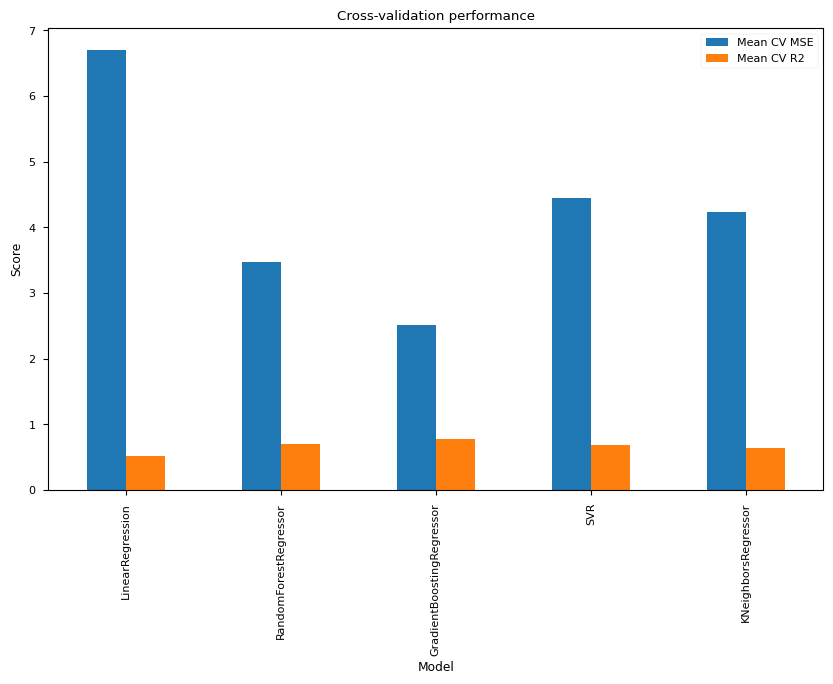

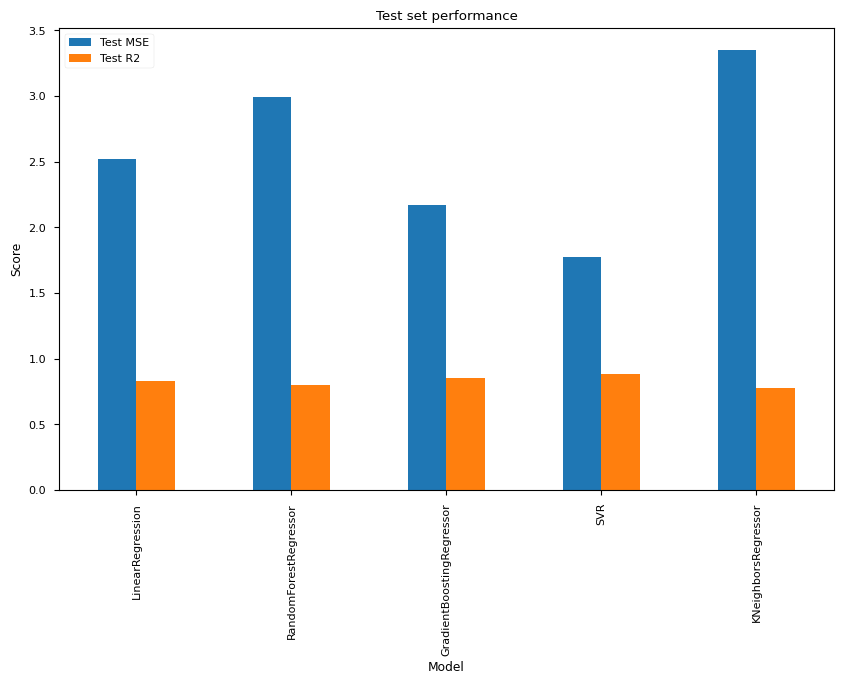

In [33]:
regression_model_comparison(df_merged, target=target)

# Ridge regression

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge_model = Ridge(alpha=1.0)

ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Ridge - MSE: {mse}')
print(f'Ridge - R2: {r2}')

Ridge - MSE: 9.28922239649167
Ridge - R2: 0.37784884673437324


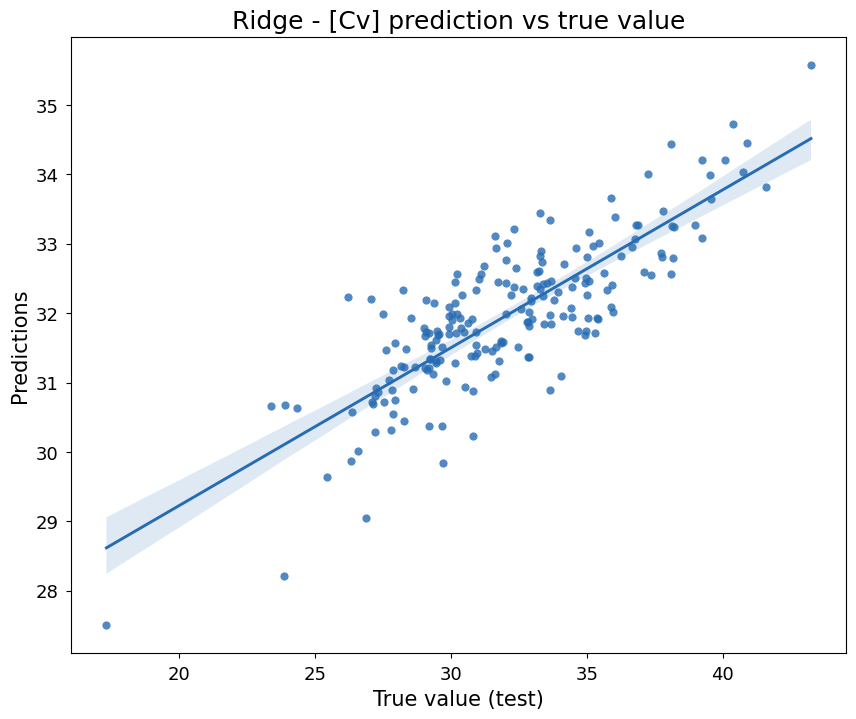

In [11]:
plt.figure(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, color=colors[1], scatter_kws={'s': 35})
plt.xlabel("True value (test)", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.title(f"Ridge - [{target}] prediction vs true value", fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

# XGBoost

In [12]:
model = xgb.XGBRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
params = {
    "n_estimators": 100,  # The number of boosting rounds
    "learning_rate": 0.1,  # Step size shrinkage
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "colsample_bytree": 1.0,  # Subsample ratio of columns when constructing each tree
    "subsample": 1.0,  # Subsample ratio of the training instances
    "reg_alpha": 0,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "booster": "gbtree",  # The type of model to use, can be 'gbtree', 'gblinear', or 'dart'
    "objective": "reg:squarederror",  # The learning task and corresponding learning objective
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    "random_state": 0,  # Random number seed
    "verbosity": 2,  # The degree of verbosity (0 = silent, 1 = warning, 2 = info, 3 = debug)
}

model = xgb.XGBRegressor(**params)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost - MSE: {mse}")
print(f"XGBoost - R2: {r2}")


XGBoost - MSE: 2.831821288562611
XGBoost - R2: 0.8103370976254394


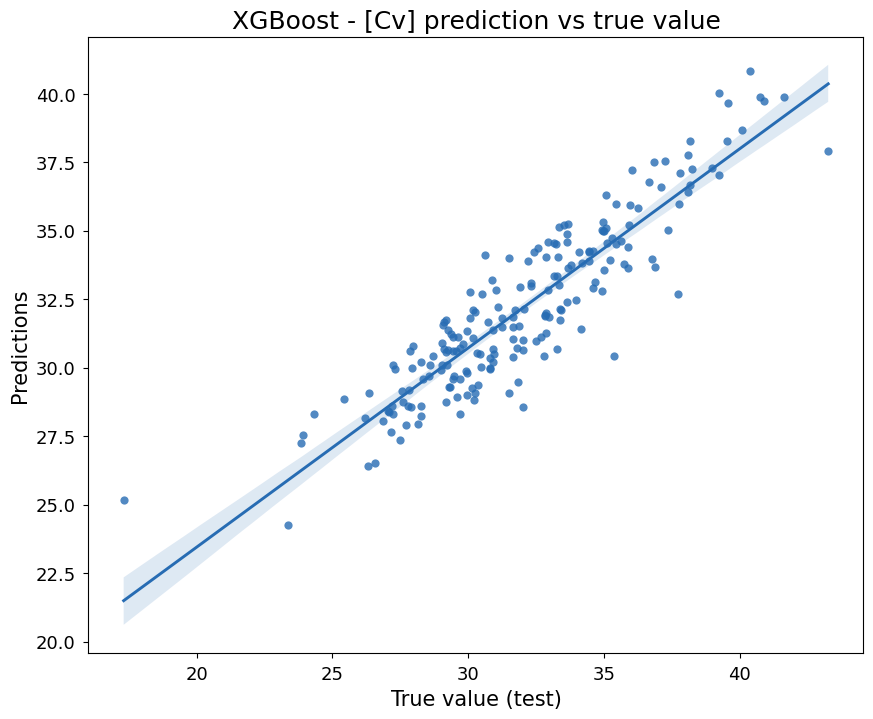

In [13]:
plt.figure(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, color=colors[1], scatter_kws={'s': 35})
plt.xlabel("True value (test)", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.title(f"XGBoost - [{target}] prediction vs true value", fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

# XGBoost feature importance

XGBoost's feature importance scores highlight each feature's contribution to the model's predictions, revealing underlying data patterns.

These scores show the most influential molecular descriptors for properties like energy at 0K, enhancing model interpretation and guiding feature selection for simpler, more interpretable models.

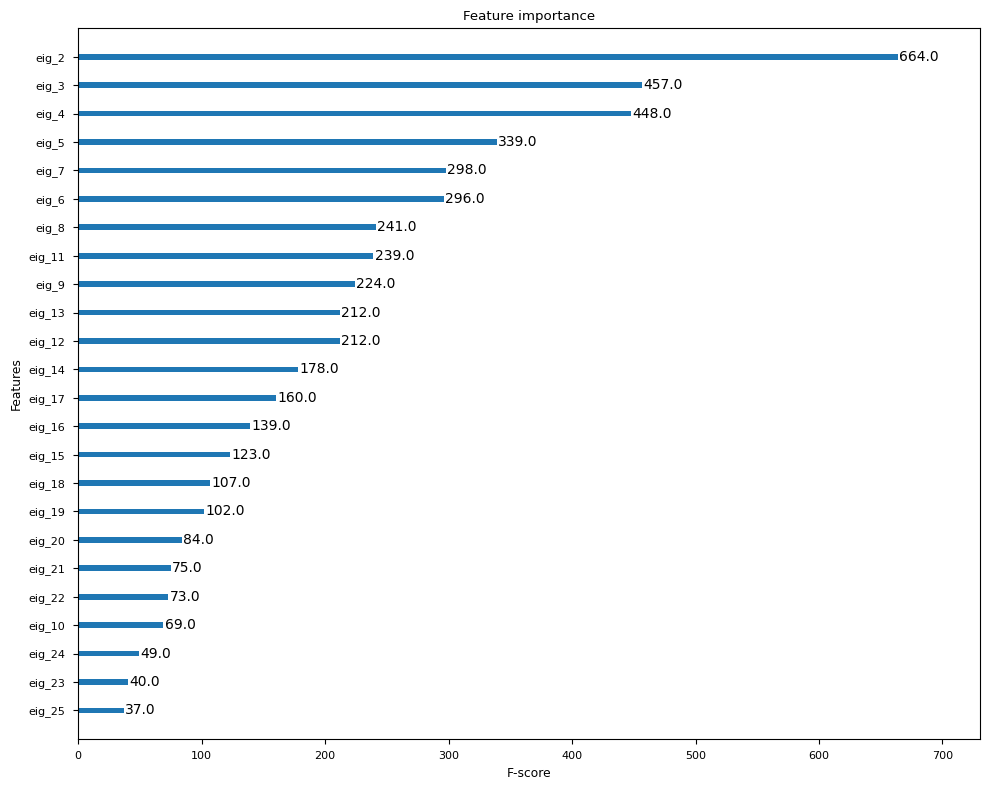

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model,
                max_num_features=resolution,
                importance_type='weight',
                title='Feature importance',
                xlabel='F-score',
                ylabel='Features',
                grid=False,
                show_values=True,
                ax=ax)

plt.tight_layout()
plt.show()